In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pandas_profiling

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [24]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,cleaned_data,cleaned_title
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,predictive model allow subject specific infere...,reconstructing subject specific effect map
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,rotation invariance translation invariance gre...,rotation invariance neural network
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,introduce develop notion spherical polyharmoni...,spherical polyharmonics poisson kernel polyhar...
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,stochastic landau lifshitz gilbert llg equatio...,finite element approximation stochastic maxwel...
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,fourier transform infra red ftir spectrum samp...,comparative study discrete wavelet transforms ...


In [10]:
print("train shape: ",train.shape)
print("test shape: ",test.shape)
print("train per: ",np.round(train.shape[0]/(train.shape[0]+test.shape[0]),decimals = 2))

train shape:  (20972, 9)
test shape:  (8989, 3)
train per:  0.7


Computer Science
0    0.590216
1    0.409784
Name: Computer Science, dtype: float64


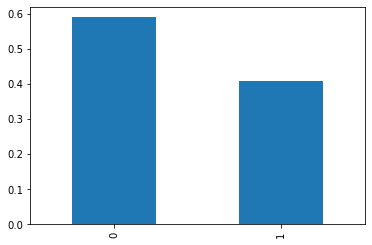

Physics
0    0.713284
1    0.286716
Name: Physics, dtype: float64


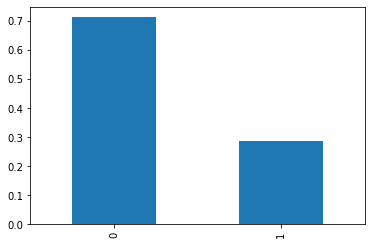

Mathematics
0    0.732119
1    0.267881
Name: Mathematics, dtype: float64


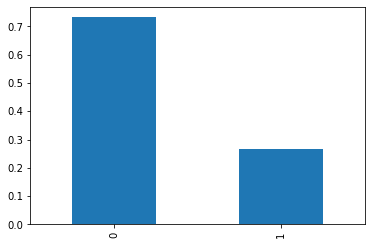

Statistics
0    0.751764
1    0.248236
Name: Statistics, dtype: float64


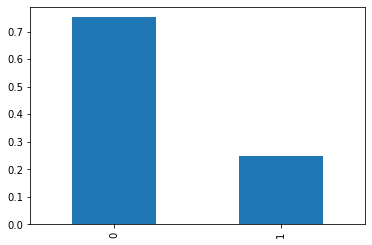

Quantitative Biology
0    0.97201
1    0.02799
Name: Quantitative Biology, dtype: float64


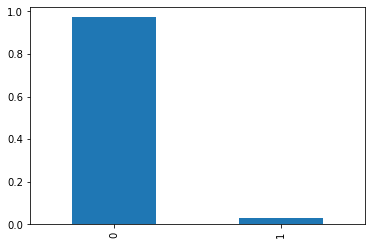

Quantitative Finance
0    0.988127
1    0.011873
Name: Quantitative Finance, dtype: float64


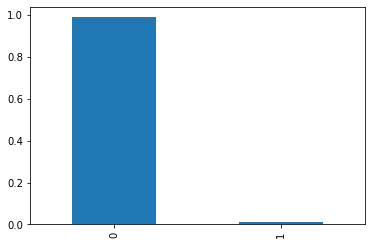

In [19]:
# labels distribution
for i in train.columns[3:]:
    print(i)
    v_c = train[i].value_counts(normalize = True)
    print(v_c)
    v_c.plot(kind='bar')
    plt.show()

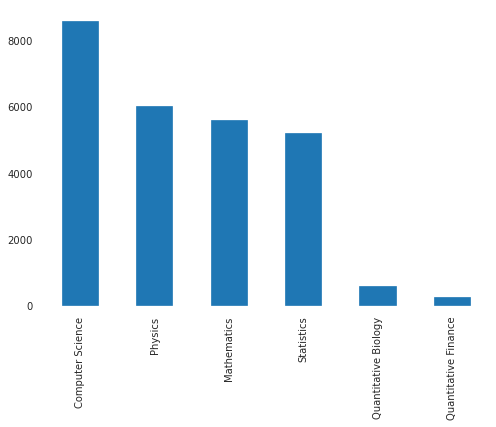

In [26]:
train.iloc[:,3:].sum(axis=0).plot(kind='bar')

1    15928
2     4793
3      251
Name: sum_labels, dtype: int64


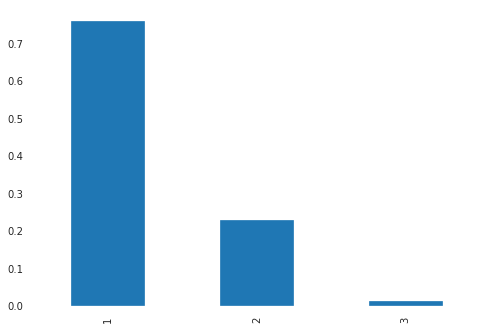

In [49]:
train['sum_labels'] = train.iloc[:,3:].sum(axis=1)
print(train['sum_labels'].value_counts())
train['sum_labels'].value_counts(normalize=True).plot(kind='bar')

In [56]:
from itertools import combinations
for i in (combinations(train.columns[3:],2)):
    try:
        count = pd.crosstab(train[train['sum_labels']==2][i[0]],train[train['sum_labels']==2][i[1]])[1][1]
        print(str(i)+' : ',count)
    except:
        count = 0
#         print(str(i)+' : ',count)

('Computer Science', 'Physics') :  437
('Computer Science', 'Mathematics') :  682
('Computer Science', 'Statistics') :  2285
('Computer Science', 'Quantitative Biology') :  30
('Computer Science', 'Quantitative Finance') :  9
('Physics', 'Mathematics') :  293
('Physics', 'Statistics') :  99
('Physics', 'Quantitative Biology') :  0
('Physics', 'Quantitative Finance') :  0
('Mathematics', 'Statistics') :  825
('Mathematics', 'Quantitative Biology') :  0
('Mathematics', 'Quantitative Finance') :  0
('Statistics', 'Quantitative Biology') :  105
('Statistics', 'Quantitative Finance') :  24
('Quantitative Biology', 'Quantitative Finance') :  4


In [55]:
from itertools import combinations
for i in (combinations(train.columns[3:],3)):
    try:
        count = train[(train[i[0]]==1) & (train[i[1]]==1) & (train[i[2]]==1)].shape[0]
        if count!=0:
            print(str(i)+' : ',count)
    except:
        count = 0
#         print(str(i)+' : ',count)

('Computer Science', 'Physics', 'Mathematics') :  19
('Computer Science', 'Physics', 'Statistics') :  36
('Computer Science', 'Mathematics', 'Statistics') :  179
('Computer Science', 'Statistics', 'Quantitative Biology') :  5
('Computer Science', 'Statistics', 'Quantitative Finance') :  2
('Physics', 'Mathematics', 'Statistics') :  9
('Mathematics', 'Statistics', 'Quantitative Finance') :  1


In [23]:
pandas_profiling.ProfileReport(train)

In [59]:
# Common Textual Features
train['TITLE'][0]

'Reconstructing Subject-Specific Effect Maps'

In [85]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [86]:
from collections import Counter

def pos_tag_features(df):
    dic_pos = {"C_NOUN":[],"C_VERB":[],"C_ADJ":[]}
    print(df.shape)
    for i in range(df.shape[0]):
        if(i%1000==0):
            print(i)
        doc = nlp(df.iloc[i,2])
        c = Counter([token.pos_ for token in doc])
        dic_pos['C_NOUN'].append(c['NOUN'])
        dic_pos['C_VERB'].append(c['VERB'])    
        dic_pos['C_ADJ'].append(c['ADJ'])      
    return pd.concat([df,pd.DataFrame(dic_pos)],axis = 1)

def creating_metaf(df):
    
    from tqdm import tqdm # I love this handy tool! 
    print(">> Generating Count Based And Demographical Features")
    df['length'] = df['ABSTRACT'].apply(lambda x : len(str(x)))
    df['capitals'] = df['ABSTRACT'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['length']),axis=1)
    df['num_exclamation_marks'] = df['ABSTRACT'].apply(lambda comment: comment.count('!'))
    df['num_question_marks'] = df['ABSTRACT'].apply(lambda comment: comment.count('?'))
    df['num_punctuation'] = df['ABSTRACT'].apply(lambda comment: sum(comment.count(w) for w in '.,;:'))
    df['num_symbols'] = df['ABSTRACT'].apply(lambda comment: sum(comment.count(w) for w in '*&$%'))
    df['num_words'] = df['ABSTRACT'].apply(lambda comment: len(comment.split()))
    df['num_unique_words'] = df['ABSTRACT'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words']
    
    return df

def common_features(df):
    return creating_metaf(pos_tag_features(df))

In [87]:
train = pos_tag_features(train)
test = pos_tag_features(test)

(20972, 11)
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
(8989, 5)
0
1000
2000
3000
4000
5000
6000
7000
8000


In [93]:
train = creating_metaf(train)
test = creating_metaf(test)

>> Generating Count Based And Demographical Features
>> Generating Count Based And Demographical Features


In [94]:
import pickle
with open ("train.pickle",'wb') as f:
    pickle.dump(train,f)
with open ("test.pickle",'wb') as f:
    pickle.dump(test,f)

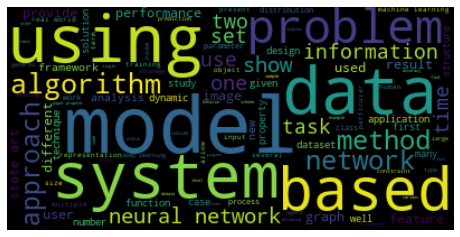

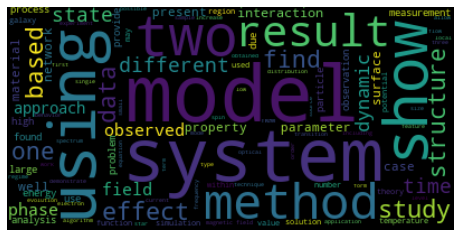

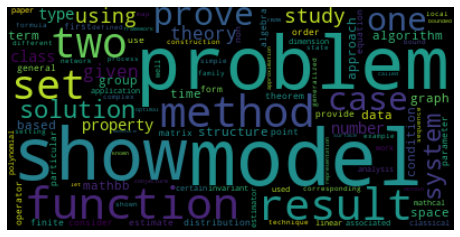

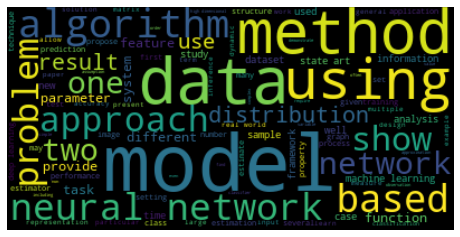

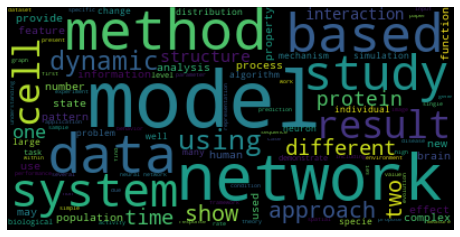

In [356]:
from wordcloud import WordCloud
for i in train.columns[3:8]:
    x = train[train[i]==1]['cleaned_data'].astype('str')
    all_words = ' '.join([text for text in x])
    wordcloud = WordCloud(max_font_size=70, max_words=100, background_color="black").generate(all_words)
    print(wordcloud)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [152]:
# Normalizing the features
from sklearn import preprocessing
x_train = train.iloc[:,11:14].values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)

In [153]:
x_test = test.iloc[:,5:8].values #returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_test_scaled = min_max_scaler.fit_transform(x)

In [4]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
# stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
from nltk.stem import WordNetLemmatizer

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


In [5]:
import re
replacement_patterns = [
  (r'won\'t', 'will not'),
  (r'can\'t', 'cannot'),
  (r'i\'m', 'i am'),
  (r'ain\'t', 'is not'),
  (r'(\w+)\'ll', '\g<1> will'),
  (r'(\w+)n\'t', '\g<1> not'),
  (r'(\w+)\'ve', '\g<1> have'),
  (r'(\w+)\'s', '\g<1> is'),
  (r'(\w+)\'re', '\g<1> are'),
  (r'(\w+)\'d', '\g<1> would')
]


class RegexpReplacer(object):
  def __init__(self, patterns=replacement_patterns):
    self.patterns = [(re.compile(regex), repl) for (regex, repl) in patterns]
    
  def replace(self, text):
    s = text
    for (pattern, repl) in self.patterns:
      s = re.sub(pattern, repl, s)
    return s
regex = RegexpReplacer()

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # expanding contractions
    sentence = regex.replace(sentence)
    
    #removing duplicate characters   
    pattern = re.compile(r"(.)\1{2,}")
    sentence = pattern.sub(r"\1", text)
    
    # remove stopwords
    text = [word for word in simple_preprocess(str(sentence)) if word not in stop_words]
    
    # lemmatization
    lemmatizer = WordNetLemmatizer()
    sentence = ' '.join(lemmatizer.lemmatize(word) for word in text)

    return sentence

train['cleaned_data'] = train['ABSTRACT'].apply(lambda x: preprocess_text(x))
test['cleaned_data'] = test['ABSTRACT'].apply(lambda x: preprocess_text(x))

In [6]:
train['cleaned_title'] = train['TITLE'].apply(lambda x: preprocess_text(x))
test['cleaned_title'] = test['TITLE'].apply(lambda x: preprocess_text(x))

In [126]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,sum_labels,...,length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,words_vs_unique
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,1,...,1912,55,0.028766,0,0,31,2,265,175,0.660377
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,1,...,513,9,0.017544,0,0,6,0,76,58,0.763158
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,1,...,668,12,0.017964,0,0,10,0,99,55,0.555556
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,1,...,783,24,0.030651,0,0,9,4,110,76,0.690909
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,2,...,860,36,0.041860,0,0,8,0,125,92,0.736000


In [133]:
train['num_words'].describe()

count    20972.000000
mean       148.404873
std         60.781306
min          1.000000
25%        104.000000
50%        145.000000
75%        190.000000
max        449.000000
Name: num_words, dtype: float64

In [10]:
embedding_dim = 100
max_length = 150
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .7

In [7]:
documents = [gensim.utils.simple_preprocess(i) for i in train['cleaned_data'].to_list() + test['cleaned_data'].to_list()]

In [ ]:
documents_title = [gensim.utils.simple_preprocess(i) for i in train['cleaned_title'].to_list() + test['cleaned_title'].to_list()]

In [331]:
from gensim.models import phrases
bigram = phrases.Phrases(documents, min_count=1, delimiter=b' ')

In [305]:
bigram

In [317]:
train['cleaned_data'][0]

'predictive model allow subject specific inference analyzing disease related alteration neuroimaging data given subject data inference made two level global identifiying condition presence subject local detecting condition effect individual measurement extracted subject data global inference widely used local inference used form subject specific effect map rarely used existing model often yield noisy detection composed dispersed isolated island article propose reconstruction method named rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise due sampling error associated using finite sample example train classifier proposed method wrapper type algorithm used different binary classifier diagnostic manner without information condition presence reconstruction posed maximum posteriori problem prior model whose parameter estimated training data classifier specific fashion experimental evaluation performed synthetica

In [343]:
doc_bi = []
doc_title_bi = []
for sen in documents:
    bigrams_ = ['_'.join(b.split(' ')) if b.count(' ') == 1 else b for b in bigram[sen]]
    doc_bi.append(bigrams_)
    
for sen in documents_title:
    bigrams_ = ['_'.join(b.split(' ')) if b.count(' ') == 1 else b for b in bigram[sen]]
    doc_title_bi.append(bigrams_)
# print(bigrams_)

In [345]:
model_wv = gensim.models.Word2Vec(
    doc_bi,
    size=100,
    window=10,
    min_count=2,
    workers=10,
    iter=100)

In [352]:
from gensim.test.utils import common_texts, get_tmpfile

In [354]:
path = get_tmpfile("word2vec.model")
model_wv.save("word2vec.model")

In [348]:
w2v_weights = model_wv.wv.vectors
vocab_size, embedding_size = w2v_weights.shape

In [349]:
print(vocab_size)

102764


In [350]:
model_wv.wv.most_similar('prediction')

[('forecasting', 0.6328619718551636),
 ('forecast', 0.6054668426513672),
 ('predictive', 0.6039746999740601),
 ('predicting', 0.5750410556793213),
 ('model', 0.5601083636283875),
 ('predictor', 0.5391886830329895),
 ('classification', 0.5190582275390625),
 ('recommendation', 0.5089318752288818),
 ('inference', 0.49451130628585815),
 ('classifier', 0.49255311489105225)]

In [351]:
w2v_weights.shape

(102764, 100)

In [156]:
train.shape

(20972, 24)

In [154]:
vocab_size

33853

In [363]:
# converting word into index
def word2token(word):
    return model_wv.wv.vocab[word].index
def token2word(token):
    return model_wv.wv.index2word[token]

In [ ]:
train_sequences = []
for k,i in enumerate(documents[:20972]):
    if(k%1000 == 0):
        print(k)
#     print()
    ls = []
    for j in i:
        if j in list(model_wv.wv.vocab):
            ls.append(word2token(j))
    train_sequences.append(ls)

In [ ]:
train_sequences = [[word2token(j) for j in i if j in list(model_wv.wv.vocab)] for i in documents[:20972]]

In [358]:
len(train_sequences)

20972

In [ ]:
test_sequences = [[word2token(j) for j in i if j in list(model_wv.wv.vocab)] for i in documents[20972:]]

In [ ]:
train_sequences_title = [[word2token(j) for j in i if j in list(model_wv.wv.vocab)] for i in documents_title[:20972]]
test_sequences_title = [[word2token(j) for j in i if j in list(model_wv.wv.vocab)] for i in documents_title[20972:]]

In [174]:
len(train_sequences)

20972

In [352]:
pd.Series([len(i) for i in train_sequences_title]).describe()

count    20972.000000
mean         7.423660
std          2.685924
min          0.000000
25%          6.000000
50%          7.000000
75%          9.000000
max         27.000000
dtype: float64

In [ ]:
# padding the sentences
from tensorflow.keras.preprocessing.sequence import pad_sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
train_padded_title = pad_sequences(train_sequences_title, maxlen=10, padding=padding_type, truncating=trunc_type)
test_padded_title = pad_sequences(test_sequences_title, maxlen=10, padding=padding_type, truncating=trunc_type)

In [17]:
y_o = train.iloc[:,3:9].values

In [441]:
y_o

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0]])

In [ ]:
# # Split the dataset into train and test subsets
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(train_padded, y, test_size=0.3, random_state=21)

train_size = int(train_padded.shape[0] * training_portion)
# indexes = np.random.randint(0,20972,train_size)
X_train = train_padded[:train_size]
y_train = y_o[:train_size]
X_train_title = train_padded_title[:train_size]

X_val = train_padded[train_size:]
X_val_title = train_padded_title[train_size:]
y_val = y_o[train_size:]

# print(train_size)
# print(len(meta_train_articles))
# print(len(train_labels))
# print(len(meta_validation_articles))
# print(len(validation_labels))

In [ ]:
X_num = x_train[:train_size]
X_val_num = x_train[train_size:]

In [ ]:
with open ("X_train.pickle",'wb') as f:
    pickle.dump(X_train,f)
with open ("X_val.pickle",'wb') as f:
    pickle.dump(X_val,f)
with open ("y_train.pickle",'wb') as f:
    pickle.dump(y_train,f)
with open ("y_val.pickle",'wb') as f:
    pickle.dump(y_val,f)
with open ("X_train_title.pickle",'wb') as f:
    pickle.dump(X_train_title,f)
with open ("X_val_title.pickle",'wb') as f:
    pickle.dump(X_val_title,f)

In [ ]:
with open ("X_train.pickle",'rb') as f:
    X_train = pickle.load(f)
with open ("X_val.pickle",'rb') as f:
    X_val = pickle.load(f)
with open ("y_train.pickle",'rb') as f:
    y_train = pickle.load(f)
with open ("y_val.pickle",'rb') as f:
    y_val = pickle.load(f)
with open ("X_train_title.pickle",'rb') as f:
    X_train_title = pickle.load(f)
with open ("X_val_title.pickle",'rb') as f:
    X_val_title.pickle = pickle.load(f)

In [102]:
with open ("X_num.pickle",'wb') as f:
    pickle.dump(X_num,f)
with open ("X_val_num.pickle",'wb') as f:
    pickle.dump(X_val_num,f)

In [445]:
y_train

array([[1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0]])

In [446]:
y_val

array([[0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       ...,
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0]])

In [407]:
X_train_title

array([[ 4046,   766,   261, ...,     0,     0,     0],
       [ 1071,  1962,    56, ...,     0,     0,     0],
       [ 1644, 21783,  1301, ...,     0,     0,     0],
       ...,
       [ 1032,   787,   409, ...,     0,     0,     0],
       [ 3810,  4975,  4501, ...,   676,   179,     0],
       [15054,  1081,   802, ...,   879,  5247,  2342]], dtype=int32)

In [167]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [217]:
# MODEL 1
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dropout,Dense,Bidirectional,Input,Embedding,Conv2D,AveragePooling2D,MaxPooling2D
from tensorflow.keras.layers import concatenate,Flatten,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D,GlobalMaxPool1D

text = Input(shape=(150,), name='text_input',dtype='int32')
y = Embedding(input_dim=33853, output_dim=embedding_dim, weights=[w2v_weights],trainable=False)(text)
# y = LSTM(100,dropout = 0.2)(y)
# y = LSTM(100,dropout = 0.2,return_sequences=True)(y)
y = LSTM(100,dropout = 0.2,return_sequences=True)(y)
y = attention()(y)
# y = Dense(50,activation='relu')(y)

# text2 = Input(shape=(10,), name='text_input2',dtype='int32')
# y2 = Embedding(input_dim=33853, output_dim=embedding_dim, weights=[w2v_weights],trainable=False)(text2)
# # y = LSTM(500,dropout = 0.5)(y)
# y2 = LSTM(100,dropout = 0.5,return_sequences=True)(y2)
# y2 = LSTM(100,dropout = 0.5)(y2)
# y2 = Dense(50,activation='relu')(y2)

title = Input(shape=(10,),name='title_input',dtype='int32')
embedding2 = Embedding(input_dim=33853, output_dim=embedding_dim, weights=[w2v_weights],trainable=False)(title)
conv2 = Conv1D(filters=32, kernel_size=2, activation='relu')(embedding2)
drop2 = Dropout(0.2)(conv2)
conv3 = Conv1D(filters=50, kernel_size=2, activation='relu')(drop2)
drop3 = Dropout(0.2)(conv3)
pool = GlobalMaxPool1D()(drop3)
# pool2 = MaxPooling1D(pool_size=2)(drop3)
# flat2 = Flatten()(pool2)
# out2 = Dense(25,activation='relu')(pool)

concat = concatenate([y,pool])

z = Dense(50,activation='relu')(concat)
z = Dropout(0.2)(z)
# z = Dense(25,activation='relu')(z)
# z = Dropout(0.2)(z)
output_y = Dense(6,activation='sigmoid')(z)
model = Model(inputs=[text,title],outputs = output_y)

2.1.0


In [273]:
# MODEL 2
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dropout,Dense,Bidirectional,Input,Embedding,Conv2D,AveragePooling2D,MaxPooling2D
from tensorflow.keras.layers import concatenate,Flatten,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

text = Input(shape=(150,), name='text_input',dtype='int32')
y = Embedding(input_dim=33853, output_dim=embedding_dim, weights=[w2v_weights],trainable=False)(text)
# y = LSTM(500,dropout = 0.5)(y)
y = LSTM(100,dropout = 0.1,return_sequences=True)(y)
y = LSTM(100,dropout = 0.1,return_sequences=True)(y)
y = attention()(y)
# y = LSTM(50,dropout = 0.1)(y)
# y = Dense(50,activation='relu')(y)

# text2 = Input(shape=(10,), name='text_input2',dtype='int32')
# y2 = Embedding(input_dim=33853, output_dim=embedding_dim, weights=[w2v_weights],trainable=False)(text2)
# # y = LSTM(500,dropout = 0.5)(y)
# y2 = LSTM(100,dropout = 0.5,return_sequences=True)(y2)
# y2 = LSTM(100,dropout = 0.5)(y2)
# y2 = Dense(50,activation='relu')(y2)

title = Input(shape=(10,),name='title_input',dtype='int32')
embedding2 = Embedding(input_dim=33853, output_dim=embedding_dim, weights=[w2v_weights],trainable=False)(title)
conv2 = Conv1D(filters=32, kernel_size=2, activation='relu')(embedding2)
drop2 = Dropout(0.1)(conv2)
conv3 = Conv1D(filters=32, kernel_size=2, activation='relu')(drop2)
drop3 = Dropout(0.1)(conv3)
pool2 = MaxPooling1D(pool_size=2)(drop3)
flat2 = Flatten()(pool2)
out2 = Dense(100,activation='relu')(flat2)

concat = concatenate([y,out2])

# z = Dense(50,activation='relu')(concat)

input_int = Input(shape=(3,))
k = Dense(50,activation='sigmoid')(input_int)

concat2 = concatenate([concat,k])
f = Dense(20,activation='relu')(concat2)
# f = Dense(20,activation='relu')(f)
# f = Dropout(0.1)(f)
output_y = Dense(6,activation='sigmoid')(f)
model = Model(inputs=[text,title,input_int],outputs = output_y)

2.1.0


In [274]:
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title_input (InputLayer)        [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, 10, 100)      3385300     title_input[0][0]                
__________________________________________________________________________________________________
conv1d_47 (Conv1D)              (None, 9, 32)        6432        embedding_52[0][0]               
__________________________________________________________________________________________________
dropout_65 (Dropout)            (None, 9, 32)        0           conv1d_47[0][0]                  
___________________________________________________________________________________________

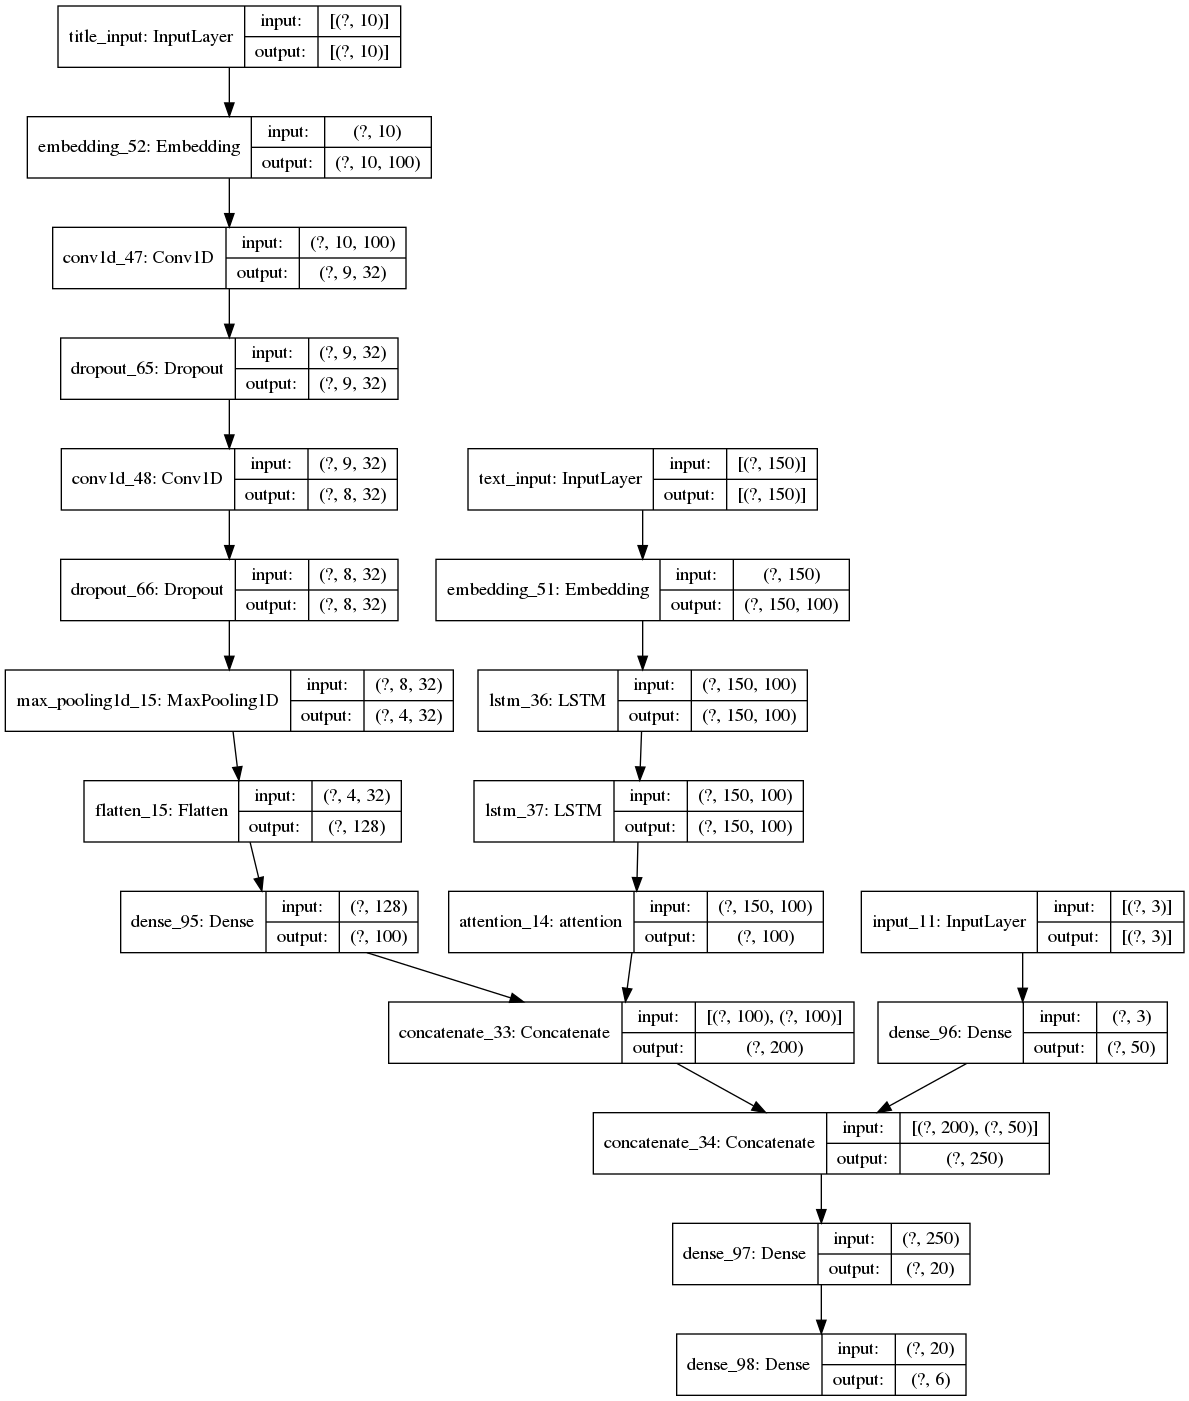

In [275]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [21]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [276]:
from sklearn.metrics import f1_score,precision_score,recall_score
from tensorflow.keras.optimizers import Adam,schedules,SGD
# def f1_m(y_true,y_pred):
#     return f1_score(y_true, y_pred, average='micro')
opt = Adam(lr=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[f1_m])

In [403]:
X_train.shape

(14680, 150)

In [404]:
X_train_title.shape

(14680, 10)

In [277]:
from tensorflow.keras import callbacks
my_callbacks = [
    callbacks.EarlyStopping(patience=6),
    callbacks.ModelCheckpoint(filepath='model6.h5',save_best_only=True,verbose=1,monitor='val_loss',mode='min'),
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=0.0001, mode='min', verbose=1, min_delta=1e-6)
]
history = model.fit([X_train,X_train_title,X_num], y_train, epochs=25, batch_size=64,validation_data=([X_val,X_val_title,X_val_num],y_val),callbacks=my_callbacks,verbose=1)

Train on 14680 samples, validate on 6292 samples
Epoch 1/25
14656/14680 [============================>.] - ETA: 0s - loss: 0.2257 - f1_m: 0.7703
Epoch 00001: val_loss improved from inf to 0.18938, saving model to model6.h5
14680/14680 [==============================] - 95s 6ms/sample - loss: 0.2256 - f1_m: 0.7706 - val_loss: 0.1894 - val_f1_m: 0.8111
Epoch 2/25
14656/14680 [============================>.] - ETA: 0s - loss: 0.1827 - f1_m: 0.8165
Epoch 00002: val_loss improved from 0.18938 to 0.18090, saving model to model6.h5
14680/14680 [==============================] - 94s 6ms/sample - loss: 0.1826 - f1_m: 0.8169 - val_loss: 0.1809 - val_f1_m: 0.8152
Epoch 3/25
14656/14680 [============================>.] - ETA: 0s - loss: 0.1703 - f1_m: 0.8267
Epoch 00003: val_loss did not improve from 0.18090
14680/14680 [==============================] - 94s 6ms/sample - loss: 0.1702 - f1_m: 0.8270 - val_loss: 0.1810 - val_f1_m: 0.8238
Epoch 4/25
14656/14680 [============================>.] - ETA:

KeyboardInterrupt: 

In [61]:
X_train.shape

(14680, 150)

In [62]:
X_train_title.shapeno attribut

(14680, 10)

In [188]:
from tensorflow.keras import models
m = models.load_model('model4.h5',custom_objects={'f1_m':f1_m,'attention':attention})

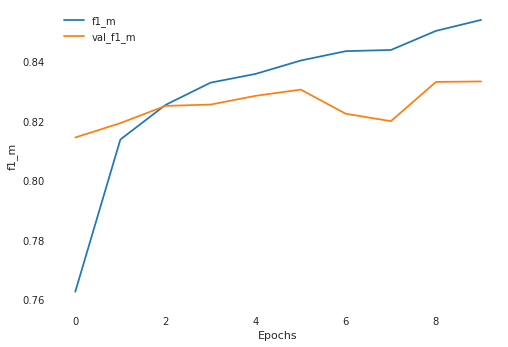

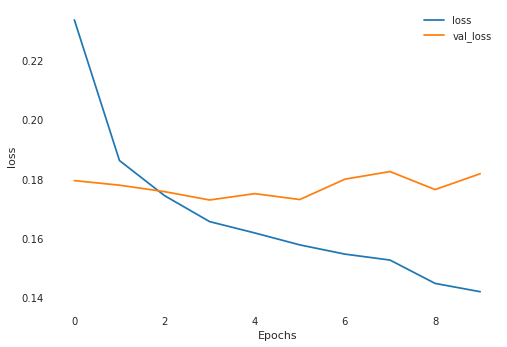

In [221]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "f1_m")
plot_graphs(history, "loss")

In [222]:
# train_prediction
predictions = model.predict([X_val,X_val_title])

In [232]:
thresholds=[0.1,0.2,0.3,0.4,0.45,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_val, pred, average='micro')
    recall = recall_score(y_val, pred, average='micro')
    f1 = f1_score(y_val, pred, average='micro')
   
    print("Micro-average quality numbers: ", val)
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Micro-average quality numbers:  0.1
Precision: 0.6877, Recall: 0.9380, F1-measure: 0.7936
Micro-average quality numbers:  0.2
Precision: 0.7444, Recall: 0.9096, F1-measure: 0.8187
Micro-average quality numbers:  0.3
Precision: 0.7825, Recall: 0.8819, F1-measure: 0.8292
Micro-average quality numbers:  0.4
Precision: 0.8134, Recall: 0.8567, F1-measure: 0.8345
Micro-average quality numbers:  0.45
Precision: 0.8251, Recall: 0.8433, F1-measure: 0.8341
Micro-average quality numbers:  0.5
Precision: 0.8385, Recall: 0.8278, F1-measure: 0.8331
Micro-average quality numbers:  0.6
Precision: 0.8607, Recall: 0.7951, F1-measure: 0.8266
Micro-average quality numbers:  0.7
Precision: 0.8836, Recall: 0.7439, F1-measure: 0.8078
Micro-average quality numbers:  0.8
Precision: 0.9106, Recall: 0.6694, F1-measure: 0.7716
Micro-average quality numbers:  0.9
Precision: 0.9432, Recall: 0.5564, F1-measure: 0.6999


In [233]:
pred=predictions.copy()

pred[pred>=0.4]=1
pred[pred<0.4]=0

In [234]:
y_val.sum(axis=0)

array([2607, 1800, 1686, 1593,  144,   78])

In [235]:
pred.sum(axis=0)

array([2829., 1729., 1683., 1864.,  151.,   73.], dtype=float32)

In [300]:
y

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.]], dtype=float32)

In [224]:
prediction = model.predict([test_padded,test_padded_title])

In [178]:
prediction.shape

(8989, 6)

In [225]:
prediction[prediction >= 0.40] = int(1)
prediction[prediction < 0.40] = int(0)

In [226]:
prediction = pd.DataFrame(prediction)

In [184]:
prediction

,0,1,2,3,4,5
0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
8984,1.0,0.0,0.0,0.0,0.0,0.0
8985,1.0,0.0,1.0,0.0,0.0,0.0
8986,0.0,0.0,0.0,0.0,1.0,0.0
8987,0.0,0.0,0.0,1.0,0.0,0.0


In [227]:
submission = pd.DataFrame({'ID':test['ID'],'Computer Science':prediction[0],'Physics':prediction[1],'Mathematics':prediction[2],'Statistics':prediction[3],'Quantiative Biology':prediction[4],'Quantitative Finance':prediction[5]})

In [228]:
submission.to_csv("7.csv",index = False)

In [239]:
train

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,sum_labels,...,length,capitals,caps_vs_length,num_exclamation_marks,num_question_marks,num_punctuation,num_symbols,num_words,num_unique_words,words_vs_unique
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,1,...,1912,55,0.028766,0,0,31,2,265,175,0.660377
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,1,...,513,9,0.017544,0,0,6,0,76,58,0.763158
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,1,...,668,12,0.017964,0,0,10,0,99,55,0.555556
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,1,...,783,24,0.030651,0,0,9,4,110,76,0.690909
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,2,...,860,36,0.041860,0,0,8,0,125,92,0.736000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20967,20968,Contemporary machine learning: a guide for pra...,Machine learning is finding increasingly bro...,1,1,0,0,0,0,2,...,1356,10,0.007375,0,0,18,0,194,130,0.670103
20968,20969,Uniform diamond coatings on WC-Co hard alloy c...,Polycrystalline diamond coatings have been g...,0,1,0,0,0,0,1,...,890,11,0.012360,0,0,13,0,134,100,0.746269
20969,20970,Analysing Soccer Games with Clustering and Con...,We present a new approach for identifying si...,1,0,0,0,0,0,1,...,1289,8,0.006206,0,0,21,0,194,123,0.634021
20970,20971,On the Efficient Simulation of the Left-Tail o...,The sum of Log-normal variates is encountere...,0,0,1,1,0,0,2,...,1318,19,0.014416,0,0,16,0,193,124,0.642487


In [320]:
submission

,ID,Computer Science,Physics,Mathematics,Statistics,Quantiative Biology,Quantitative Finance
0,20973,1.0,0.0,0.0,1.0,0.0,0.0
1,20974,0.0,1.0,0.0,0.0,0.0,0.0
2,20975,1.0,0.0,0.0,0.0,0.0,0.0
3,20976,0.0,1.0,0.0,0.0,0.0,0.0
4,20977,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
8984,29957,1.0,0.0,0.0,0.0,0.0,0.0
8985,29958,1.0,0.0,0.0,0.0,0.0,0.0
8986,29959,1.0,0.0,0.0,1.0,0.0,0.0
8987,29960,1.0,0.0,0.0,1.0,0.0,0.0
